 # **FORECASTING COVID DEATHS**

### Importing the libraries and the data

The data are public and can be downloaded in Kaggle in the following link : <br>
   https://ourworldindata.org/covid-deaths


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sma
import pmdarima
from pmdarima.arima import ndiffs, nsdiffs
from scipy.stats import shapiro
import seaborn as sns
from datetime import datetime
import scipy.stats as st
import warnings
import os
from scipy.stats import pearsonr
#from src import plot_functions as plf
import matplotlib.colors as mcolors
#
#import pandas_profiling
#from pandas_profiling import ProfileReport
warnings.filterwarnings("ignore")

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import statsmodels.api as sm
import os

In [195]:
#!pip install --upgrade scipy
!pip install pandas numpy pmdarima

In [236]:
file_name = 'owid-covid-data.csv'
path = os.path.join(os.getcwd(), file_name)
data = pd.read_csv(file_name,sep = ',')

#### Selecting the relevant columns
The variable we are going to predict is "new_deaths" it refers to the deaths of Covid's patients

In [237]:
data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [238]:
col_selected= ['iso_code','date', 'new_deaths', 'total_cases_per_million','new_cases','icu_patients', 'hosp_patients'
               ,'new_tests','total_tests_per_thousand','people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred', 'hospital_beds_per_thousand','positive_rate']

This analysis will be focused on a specific country, in order to select the country it's possible to check the avability of the key data.

In [239]:
#finding the country with longer time series useful data: 
#we are intrasted in the new deths and the new cases mostly.
iso = []
start_dates = []
last_dates = []
availability = []
for iso_code in list(data['iso_code'].unique()):
    data_country = data[data['iso_code']== iso_code]
    first_available= data_country[data_country['new_cases']>=1]
    if first_available.shape[0] > 0:
        first_available=  first_available['date'].iloc[0]
        data_country_sel = data_country[data_country['date']>=first_available]
        last_available= data_country_sel[data_country_sel['new_deaths']>=1]
        if last_available.shape[0] > 0:
            last_available_date =last_available['date'].iloc[-1]
            data_country_sel = data_country_sel[data_country_sel['date']<=last_available_date]
            #selecting the number of available rows
            lines= data_country_sel.shape[0]

            iso.append(iso_code)
            start_dates.append(first_available)
            last_dates.append(last_available_date)
            availability.append(lines)
        else:
            pass
available_df = pd.DataFrame({'iso': iso, 'start_dates': start_dates, 'last_dates': last_available_date, 'availability': availability})


In [240]:
available_df = available_df.sort_values(by='availability',  ascending=False)
available_df.iloc[:15]

,iso,start_dates,last_dates,availability
69,OWID_EUR,2020-01-05,2024-03-03,1562
94,OWID_HIC,2020-01-05,2024-03-03,1562
234,OWID_WRL,2020-01-05,2024-03-03,1562
227,OWID_UMC,2020-01-05,2024-03-03,1562
70,OWID_EUN,2020-01-05,2024-03-03,1562
12,OWID_ASI,2020-01-05,2024-03-03,1562
44,CHN,2020-01-05,2024-03-03,1562
212,THA,2020-01-19,2024-03-03,1548
157,OWID_NAM,2020-01-26,2024-03-03,1541
13,AUS,2020-01-26,2024-03-03,1541


I am chosing Italy, the European country with the longest available time series, because it's easier to comment the result given my domain knowdlege. 

In [241]:
data= data[data['iso_code']=='ITA']
data= data[col_selected]
#dropping the no longer needed iso_code col
data.drop(columns=['iso_code'],inplace = True)
#selecting the dates 
data = data[data['date'] >= available_df['start_dates'].iloc[0]]
data = data[data['date'] <= available_df['last_dates'].iloc[0]]
data

,date,new_deaths,total_cases_per_million,new_cases,icu_patients,hosp_patients,new_tests,total_tests_per_thousand,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,hospital_beds_per_thousand,positive_rate
168634,2020-01-05,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18,NaN
168635,2020-01-06,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18,NaN
168636,2020-01-07,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18,NaN
168637,2020-01-08,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18,NaN
168638,2020-01-09,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170149,2024-02-28,0.0,452517.598,0.0,45.0,1199.0,NaN,NaN,NaN,NaN,NaN,3.18,NaN
170150,2024-02-29,0.0,452517.598,0.0,44.0,1179.0,NaN,NaN,NaN,NaN,NaN,3.18,NaN
170151,2024-03-01,0.0,452517.598,0.0,36.0,1171.0,NaN,NaN,NaN,NaN,NaN,3.18,NaN
170152,2024-03-02,0.0,452517.598,0.0,29.0,1163.0,NaN,NaN,NaN,NaN,NaN,3.18,NaN


In [242]:
data.columns

Index(['date', 'new_deaths', 'total_cases_per_million', 'new_cases',
       'icu_patients', 'hosp_patients', 'new_tests',
       'total_tests_per_thousand', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'hospital_beds_per_thousand', 'positive_rate'],
      dtype='object')

In [243]:
def plot_and_save_variables(df, y1_var_name, y2_var_name, temp='Daily'):
    # function that shows the graph of the two timeseries variables
    x = df.index
    y1 = df[y1_var_name]
    y2 = df[y2_var_name]

    # Create the graph
    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax2 = ax1.twinx()
    ax1.plot(x, y1, 'b-', label=y1_var_name)
    ax2.plot(x, y2, 'r-', label=y2_var_name)

    if temp == 'Weekly':
        plt.xticks(x[::40], pd.to_datetime(x[::40]).strftime('%Y-%m-%d' ))
    elif temp == 'Daily':
        plt.xticks(x[::80], pd.to_datetime(x[::80]).strftime('%Y-%m-%d' ))
    elif temp == 'Small':
        plt.xticks(x[::10], pd.to_datetime(x[::10]).strftime('%Y-%m-%d' ))

    # Personalizar el gráfico
    ax1.set_ylabel(y1_var_name, color='b',)
    ax2.set_ylabel(y2_var_name, color='r')
    plt.title(f'{y1_var_name} vs {y2_var_name}')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines + lines2, labels + labels2, loc='upper left')

    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
    plt.show()

### Graphic analysis

The 1st kind of graph plotted shows the time series of the target variables and the other predictors

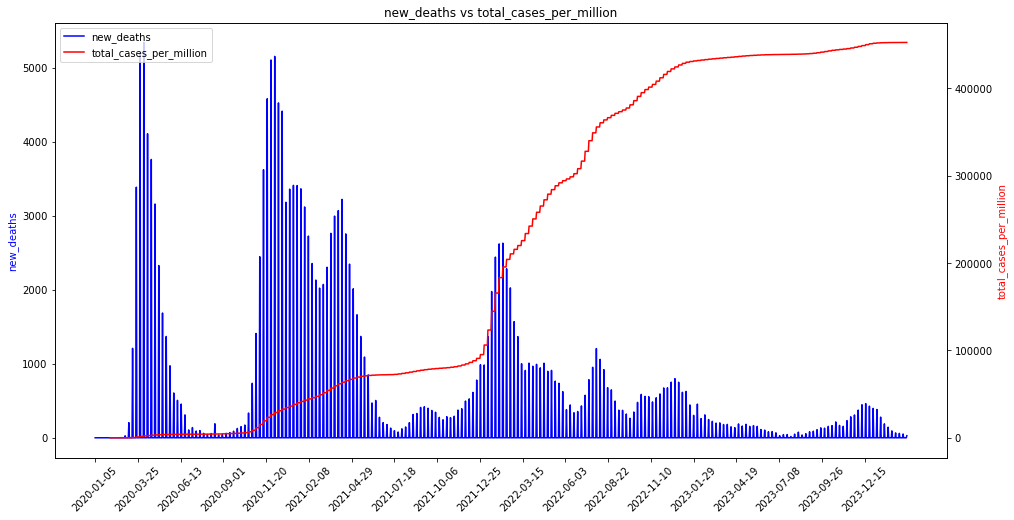

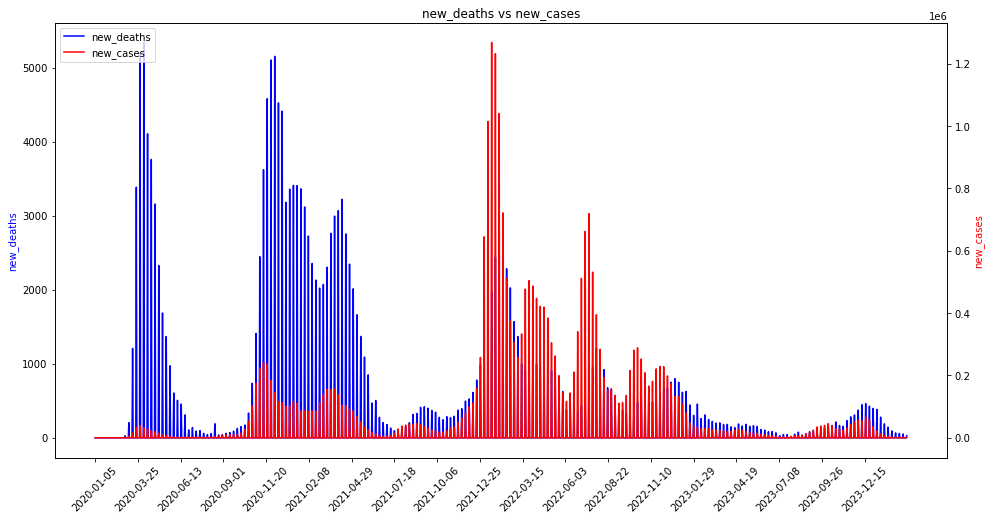

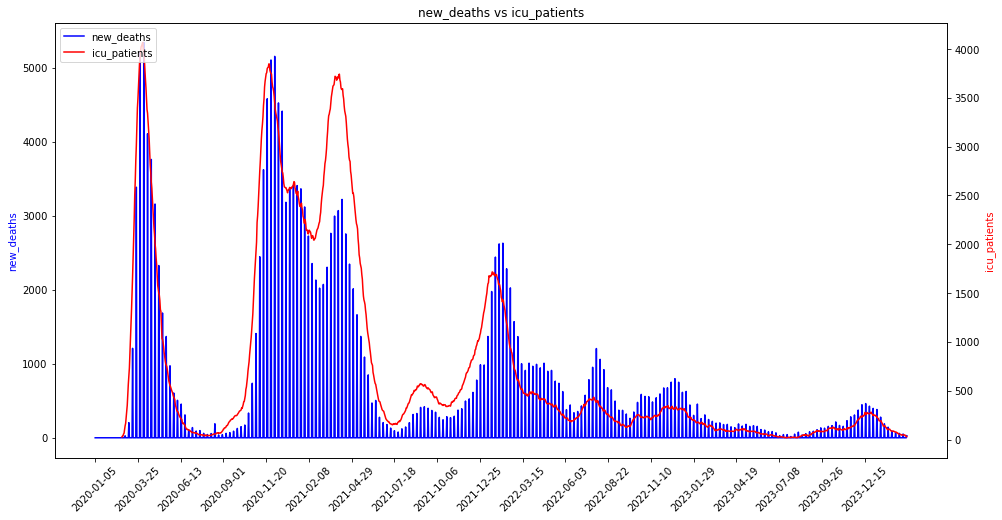

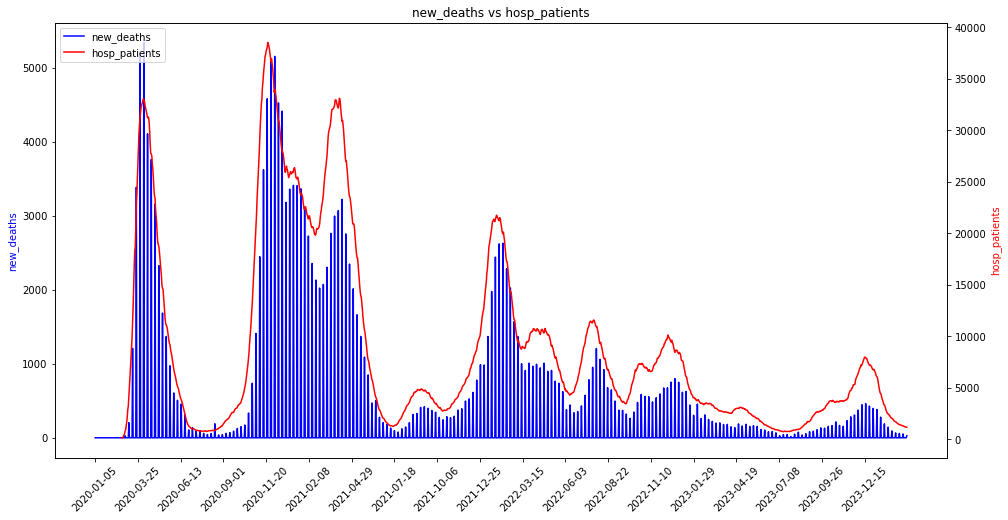

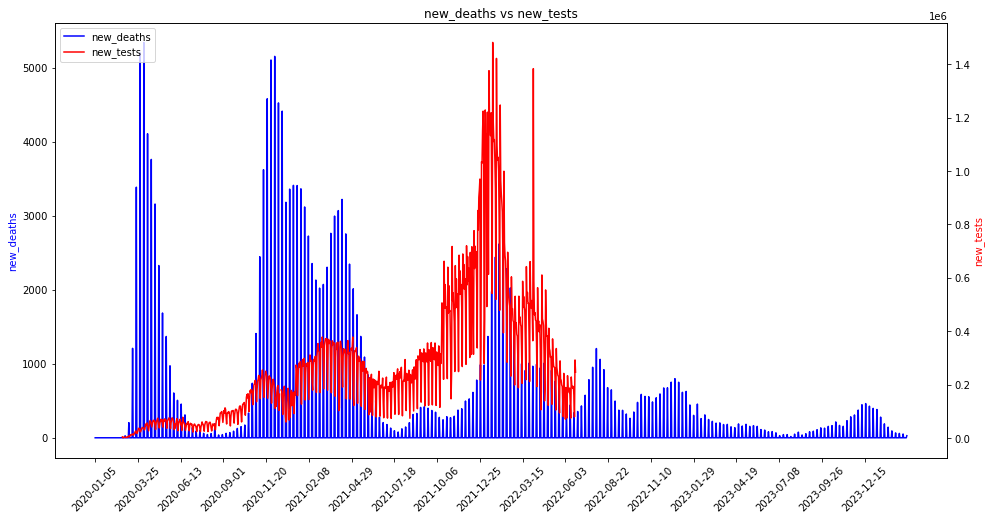

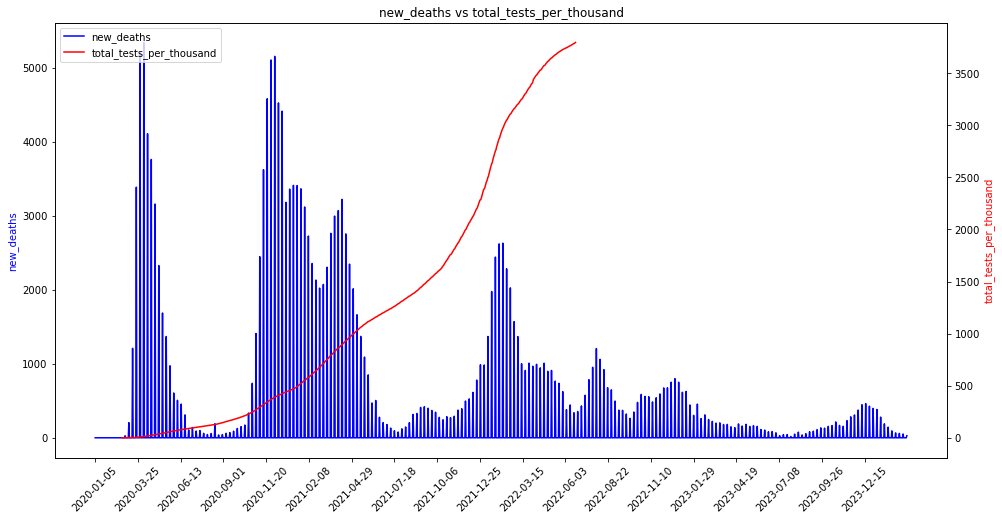

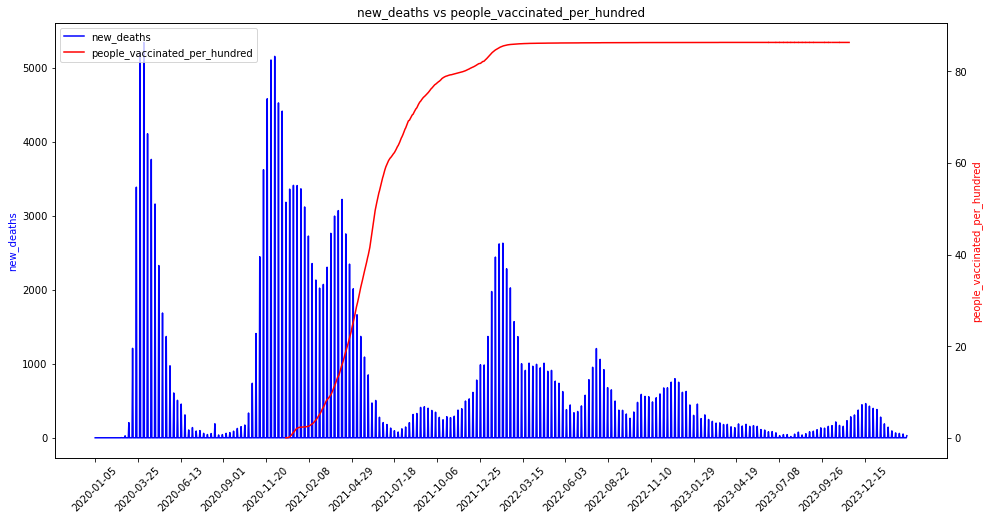

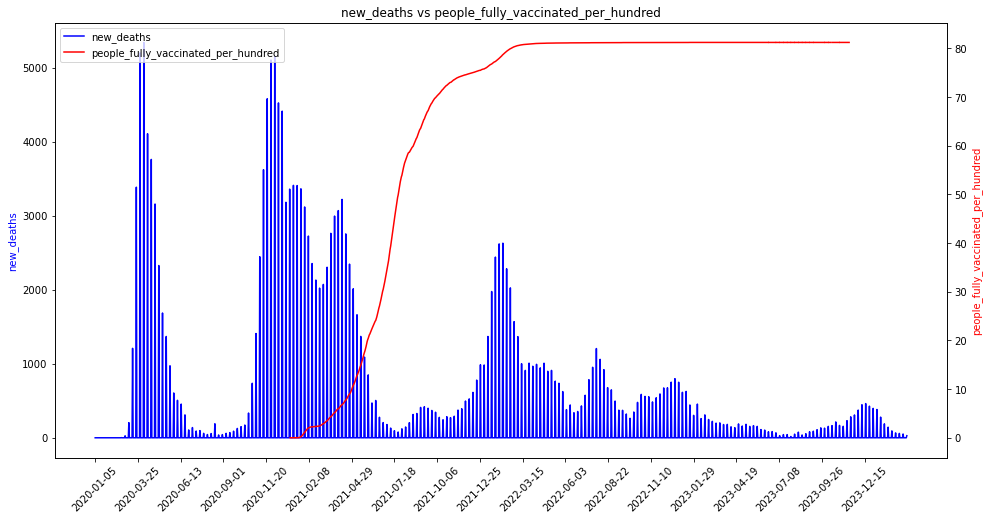

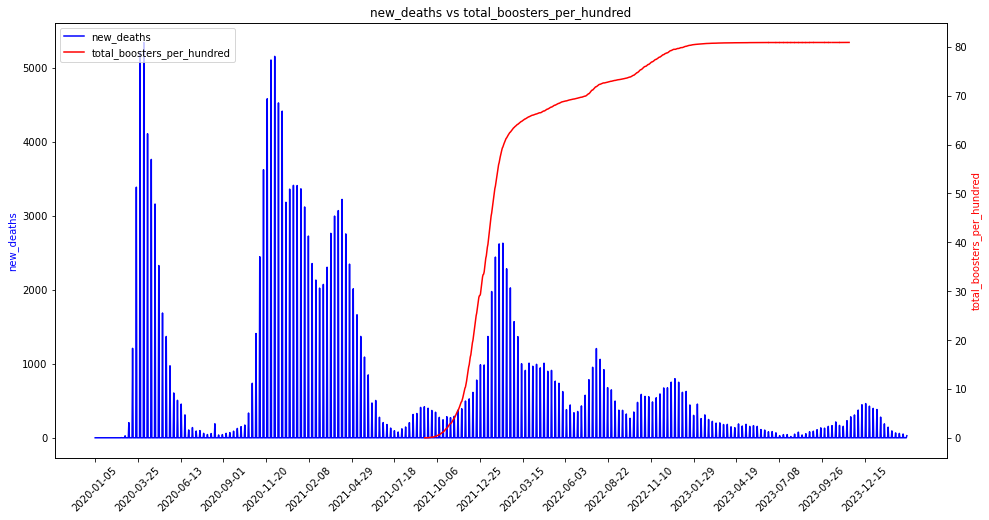

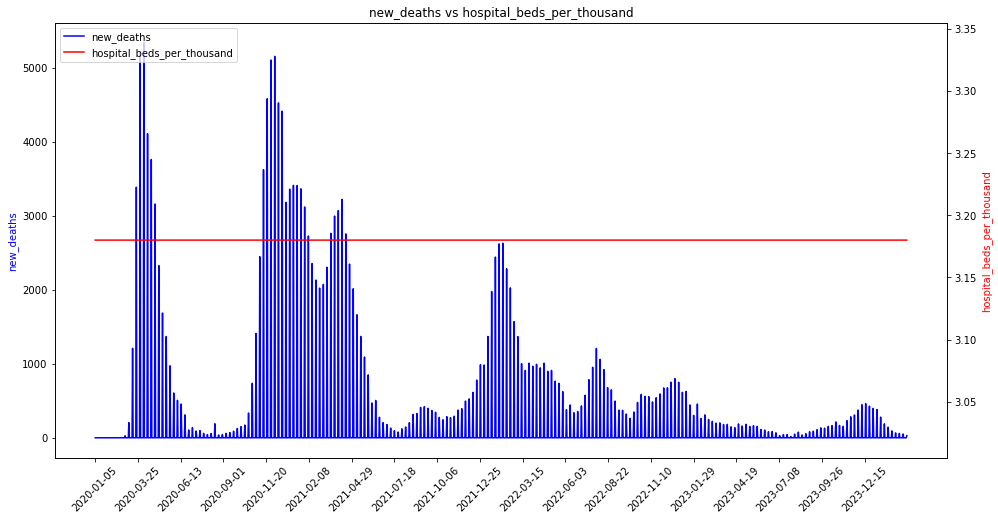

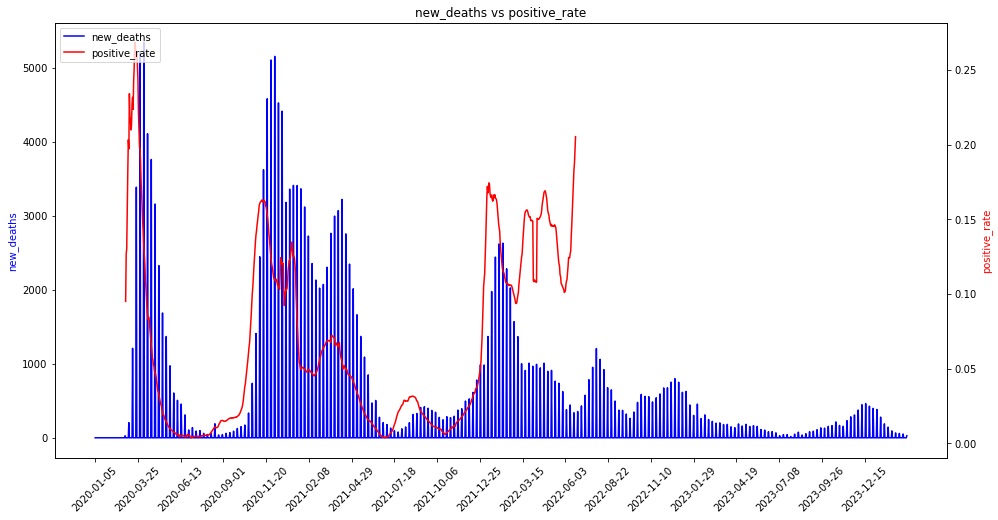

In [244]:
data.set_index('date', inplace = True)
target_var = 'new_deaths'
for col in data.columns:
    if col != target_var:
        plot_and_save_variables(data, target_var, col, temp='Daily')

### From those graph analysis we can tell that: <br>
The target variable "new_deaths" is not stationary at all because the mean and the variance changes over time. <br>
Even though the the variable does present seasonality it has trends and ciclycity.<br>

The variable "New_cases" seems correlated to the target variable even if i't s peak is surprisingly at the beginning if 2021 when we might have expected to see that peak way before. <br>
It makes sense if we see the behaviour of the variable tests that shows an high increase exactly in the same period. <br>
It would be more correct to consider the ratio or positivity.

The problem of that ratio is that we have limited data so we would have to find a way to predict the last year and half of that variable if we want include the info in the analysis.

Those variables which have too many null values will be discarded from the analysis like new_tests, and positivity rate.


After the analysis of the variance we will decide how to deal with it for not loosing the precious predictive variable " new cases".

The cumulative variables (like total deaths, total people vaccinated) can help the prevision but they need to turned into categorical variables representing the level of each dimension.

We can assume that the number of vaxs before the 1st observation was equal to 0 and we can subsitute the highest value of the distribution for all the last values.


The variables like icu ( intensive care patients) and number of hospitalization are very correlated.

The variable hospital in beds is constant, it can be eliminated.


In [245]:
# deleting unuseful variables : 
data.columns

Index(['new_deaths', 'total_cases_per_million', 'new_cases', 'icu_patients',
       'hosp_patients', 'new_tests', 'total_tests_per_thousand',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'total_boosters_per_hundred', 'hospital_beds_per_thousand',
       'positive_rate'],
      dtype='object')

In [246]:
col_to_del = ['hospital_beds_per_thousand', 'new_tests', 'total_tests_per_thousand', 'positive_rate']

In [247]:
data.drop(columns=col_to_del,inplace=True)

In [248]:
#checking the granularity of all the variables selecting one month to see the detail 
#data_granularity = data[data.index>'2020-03-15']
#data_granularity = data_granularity[data_granularity.index<'2020-04-15']

In [249]:
start_date= data.index.min()
end_date = data.index.max()
weekly_index = pd.date_range(start=start_date, end=end_date, freq='W')
weekly_index

DatetimeIndex(['2020-01-05', '2020-01-12', '2020-01-19', '2020-01-26',
               '2020-02-02', '2020-02-09', '2020-02-16', '2020-02-23',
               '2020-03-01', '2020-03-08',
               ...
               '2023-12-31', '2024-01-07', '2024-01-14', '2024-01-21',
               '2024-01-28', '2024-02-04', '2024-02-11', '2024-02-18',
               '2024-02-25', '2024-03-03'],
              dtype='datetime64[ns]', length=218, freq='W-SUN')

In [250]:
data.index = pd.to_datetime(data.index)
data.index

DatetimeIndex(['2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14',
               ...
               '2024-02-23', '2024-02-24', '2024-02-25', '2024-02-26',
               '2024-02-27', '2024-02-28', '2024-02-29', '2024-03-01',
               '2024-03-02', '2024-03-03'],
              dtype='datetime64[ns]', name='date', length=1520, freq=None)

In [251]:
weekly_df = pd.DataFrame(index=weekly_index)

In [252]:
col_same = ['new_deaths','new_cases']

In [253]:
for col in col_same:
    weekly_df[col] = data[col]
for col in data.columns: 
    if col not in col_same: 
        weekly_df[col] = data[col].resample('W').mean()

In [254]:
weekly_df

,new_deaths,new_cases,total_cases_per_million,icu_patients,hosp_patients,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred
2020-01-05,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-19,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,0.0,3.0,0.051000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-02-04,93.0,3171.0,452379.736143,97.285714,2189.428571,NaN,NaN,NaN
2024-02-11,66.0,2450.0,452431.703429,82.142857,1810.571429,NaN,NaN,NaN
2024-02-18,59.0,1727.0,452471.452857,64.571429,1510.000000,NaN,NaN,NaN
2024-02-25,51.0,1244.0,452499.536286,48.571429,1335.571429,NaN,NaN,NaN


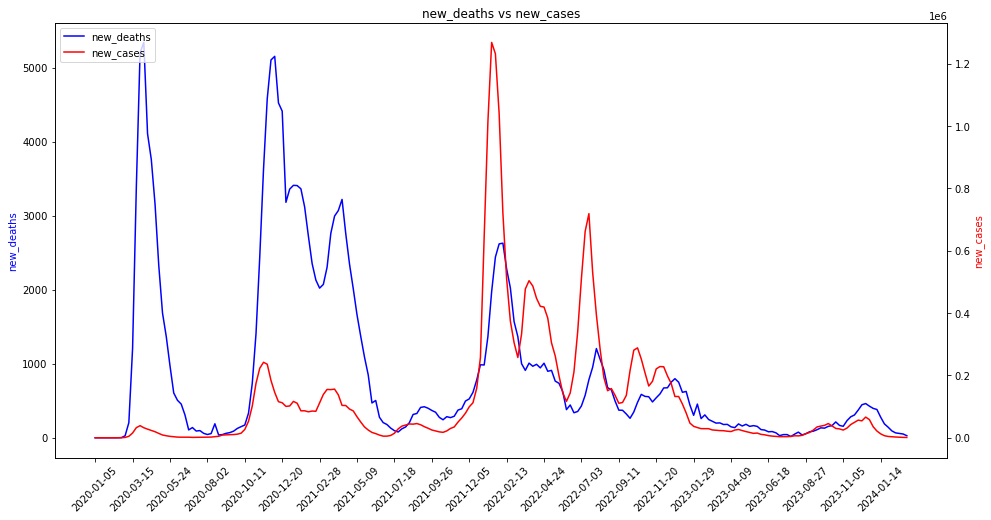

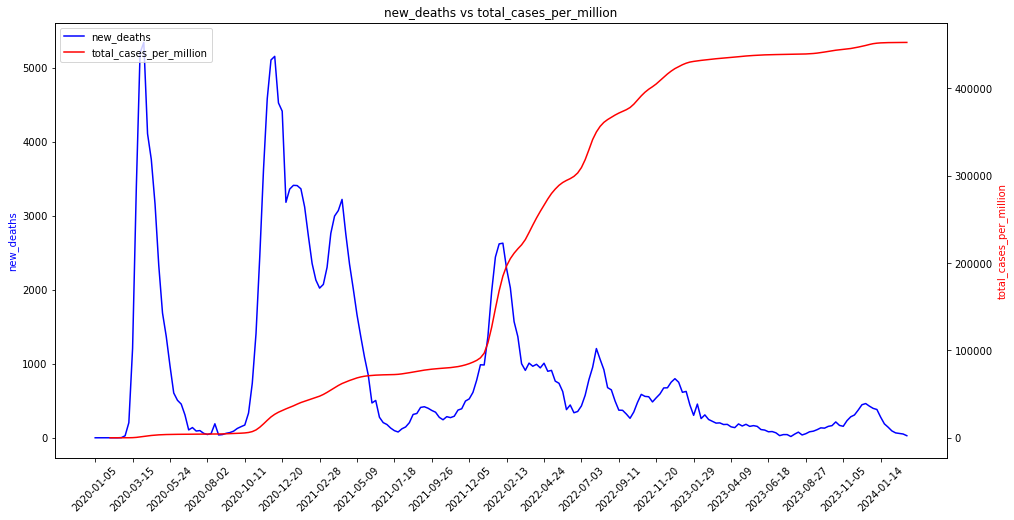

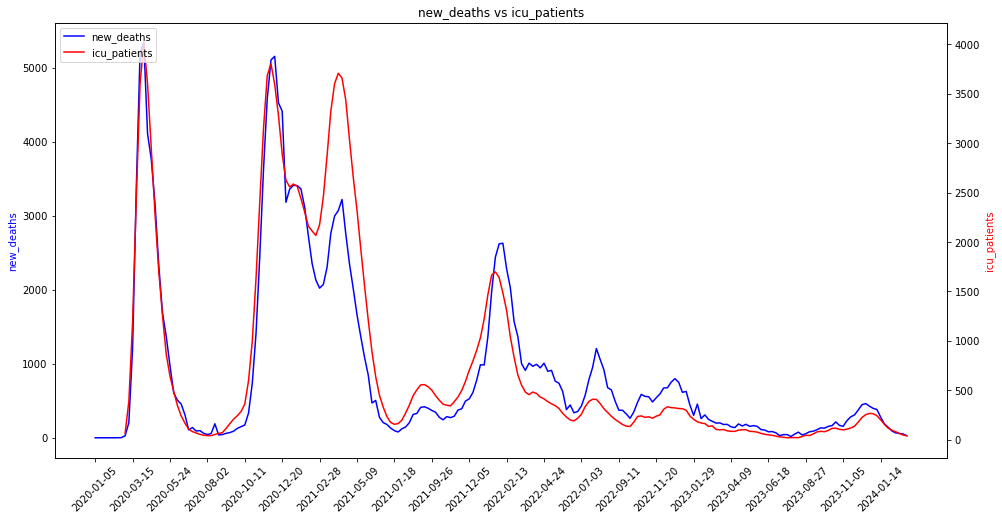

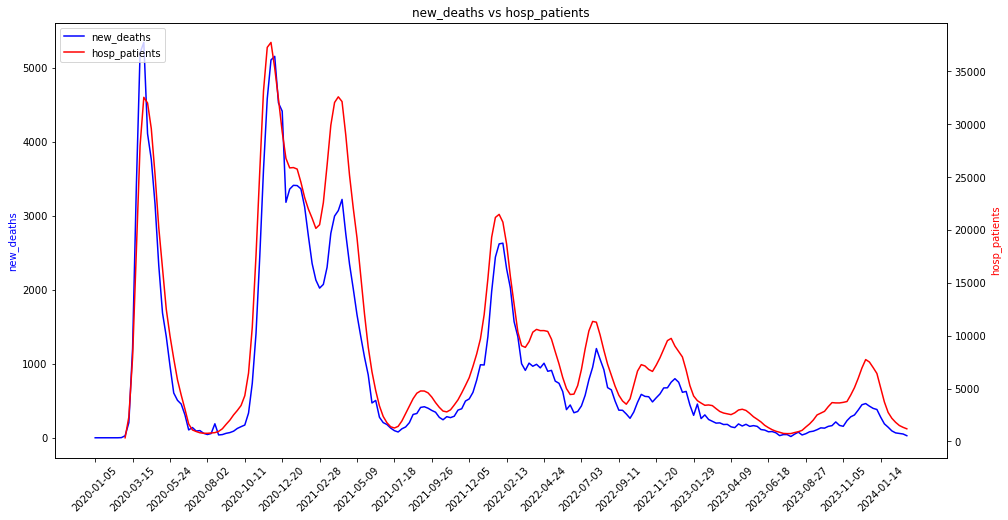

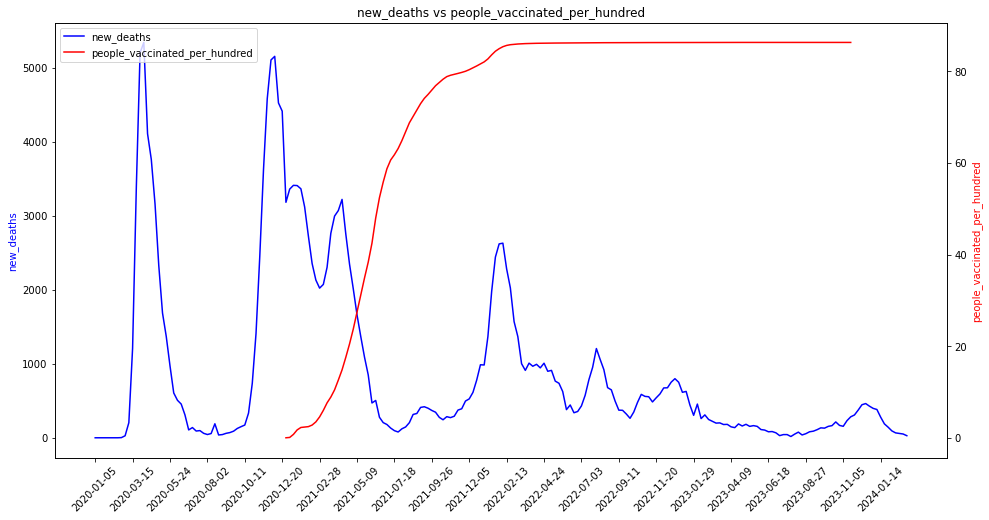

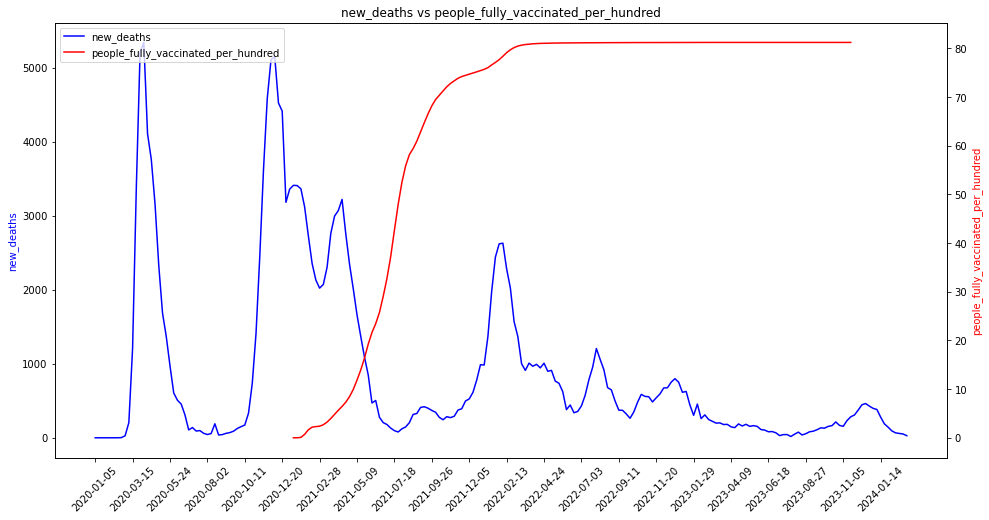

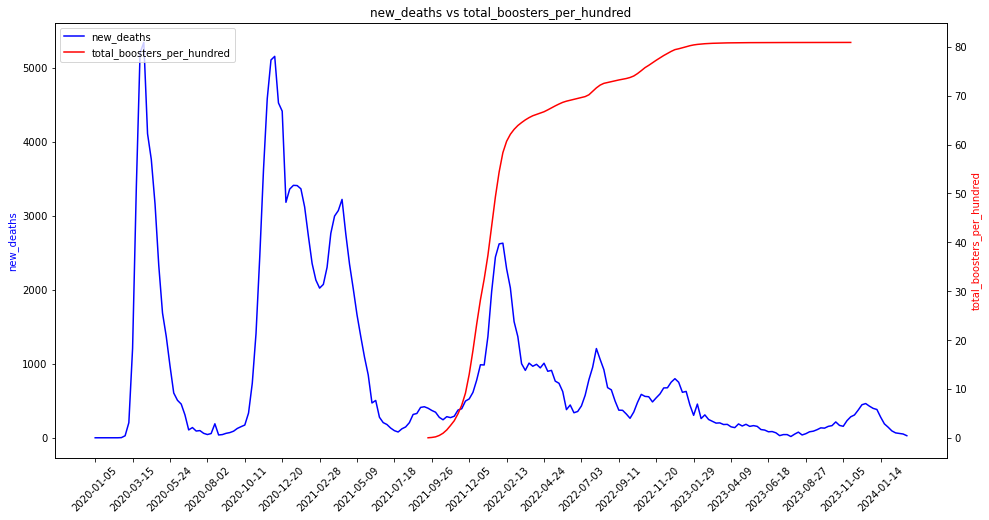

In [255]:
target_var = 'new_deaths'
for col in weekly_df.columns:
    if col != target_var:
        plot_and_save_variables(weekly_df, target_var, col, temp='Small')


In [256]:
col_to_fill = ['people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred','total_boosters_per_hundred' ]
# filling na values for the vaccination variables
for col in col_to_fill:
    first_valid = weekly_df[col].first_valid_index()
    weekly_df.loc[weekly_df.index < first_valid, col] = 0
    last_valid = weekly_df[col].last_valid_index()
    value_at_last_valid = weekly_df[col].loc[last_valid]
    weekly_df.loc[weekly_df.index > last_valid, col] = value_at_last_valid
    

In [257]:
last_valid = weekly_df['people_vaccinated_per_hundred'].last_valid_index()
last_valid
value_at_last_valid_index = weekly_df['people_vaccinated_per_hundred'].loc[last_valid]
value_at_last_valid_index

86.28

In [258]:
weekly_df.columns

Index(['new_deaths', 'new_cases', 'total_cases_per_million', 'icu_patients',
       'hosp_patients', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred'],
      dtype='object')

### Scatterplots 

In [259]:
def scatterplot_for_years(df, col, target_variable):
    # Create a figure a scatterplot and add a regression line.
    # All the years has a different colours.
    # IMPORTANT: the function consider the 1st not null value for the X and from there it fill it,
    # that could lead to bias mostly for the initial period.

    fig, ax = plt.subplots(figsize=(7, 4))
    if 'YEAR' not in df.columns:
        df['YEAR'] = df.index.year

    # Extract unique 'YEAR' values
    unique_years = df['YEAR'].unique()
    num_unique_years = len(unique_years)

    # Create a custom colormap based on the number of unique years
    colors = plt.get_cmap('viridis')(np.linspace(0, 1, num_unique_years))
    custom_cmap = mcolors.ListedColormap(colors)

    # Create a normalization object for the colormap
    norm = mcolors.Normalize(vmin=unique_years.min(), vmax=unique_years.max())

    # Extract data for the scatter plot
    # first not null value
    first_not_null = df.index[df[col].notnull()].min()
    x_data = df.loc[first_not_null:]
    x_data = x_data[col].fillna(method='ffill').fillna(method='bfill') 


    y_data = df.loc[first_not_null:,target_variable]

    year_values = df.loc[first_not_null :,'YEAR']

    # Create scatter plot
    scatter = ax.scatter(x_data, y_data, c=year_values, cmap=custom_cmap, norm=norm)

    # Fit the linear regression model
    x_data_filled = x_data.fillna(method='ffill').fillna(method='bfill')

    X = sm.add_constant(x_data_filled)
    model = sm.OLS(y_data, X).fit()


    intercept, slope = model.params
    r_squared = model.rsquared


    ax.plot(x_data_filled, intercept + slope * x_data_filled, color='red', label=f'Line')

    # Display R-squared value on the plot
    ax.text(0.05, 0.9, f'R-squared = {r_squared:.2f}', transform=ax.transAxes, fontsize=10, color='red')

    # Set labels and title for the plot
    ax.set_xlabel(col)
    ax.set_ylabel(target_variable)
    ax.set_title(f'Scatter Plot of {col}')

    # Create legend elements based on unique 'YEAR' values
    legend_elements = [mlines.Line2D([], [], marker='o', color='w', label=str(year),
                                      markersize=6, markerfacecolor=custom_cmap(norm(year)))
                       for year in unique_years]

    # Add legend with legend elements on the right
    ax.legend(handles=legend_elements, title='YEAR', loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    df.drop(columns = ['YEAR'],inplace = True)

    plt.show()


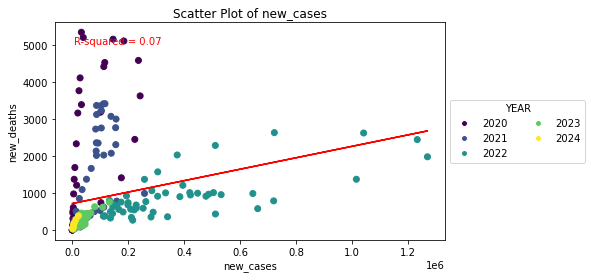

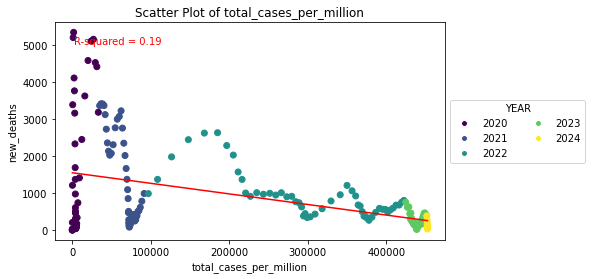

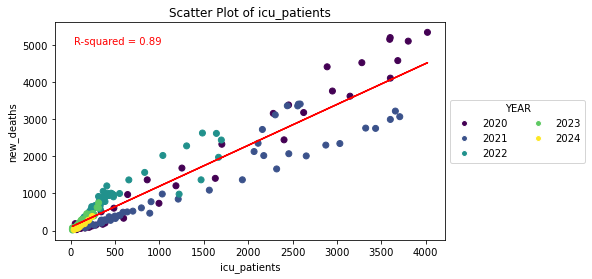

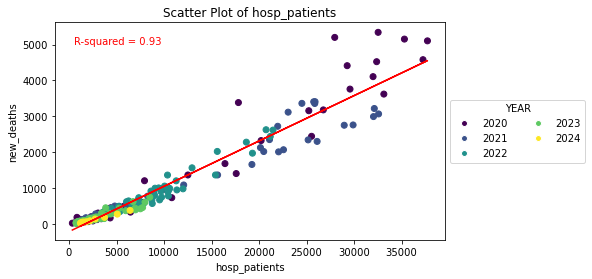

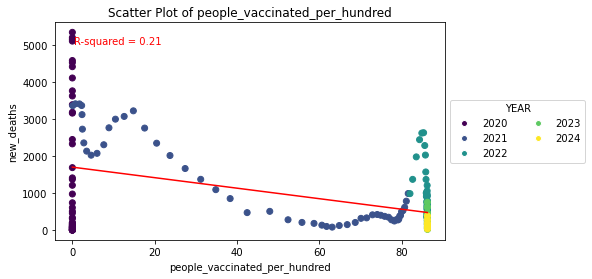

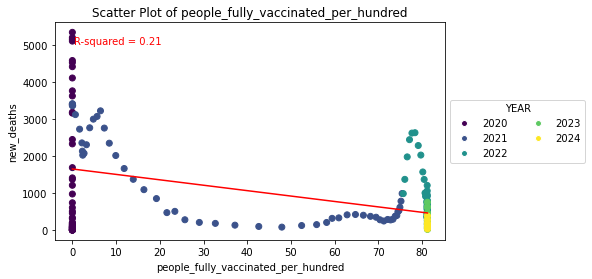

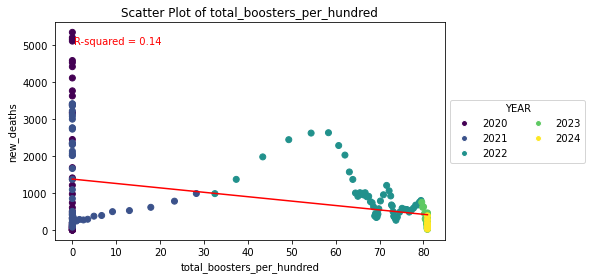

In [260]:
target_var = 'new_deaths'
for col in weekly_df.columns:
    if col != target_var:
        scatterplot_for_years(weekly_df,  col,target_var)


The Total variables has a relationship but how it was expected is not linear.
A way of including those variables is to create bins and one hot encoding to include them in the relationship as dummy.

The variable new cases does not look correlated for all the sample. If the rolling correlation confirm that we can remove the variable.




### Rolling correlation
The following graphs shows the value of the correlation for a given window and the time series of the target variable.
In this case for predictin 100 horizions we should have a window of 150 values at least

In [261]:
def rolling_corr(variable1, variable2, window):
    #OLD FUNCTION
    # calculate the rolling correlation used to calculate the correlations over time
    roll_corr = variable1.rolling(window=window).corr(variable2)
    return roll_corr

def print_correlation_over_time(df, col, target_variable ,temp = 'Small',window = 100):

    # this function show how the rolling correlation between the 2 variable analyzed in the same moment has
    # changed over time and return an image buffer.
    for variable_explicativa in [col]:
        if col != target_variable and col != 'YEAR':
            df1 = df[[variable_explicativa, target_variable]]
            df1 = df1.loc[df.index[df[col].notnull()].min():]
            name = f'corr_{variable_explicativa}_{target_variable}'
            df1[name] = rolling_corr(df[variable_explicativa], df[target_variable], window = window)
            #datetime_index = df.index.tolist()[window]
            #corr_avg_df = df1.loc[:datetime_index, [variable_explicativa, variable_objetivo]]
            corr= df1[name].mean()
            plot_and_save_variables( df1, target_variable, name,temp= temp )


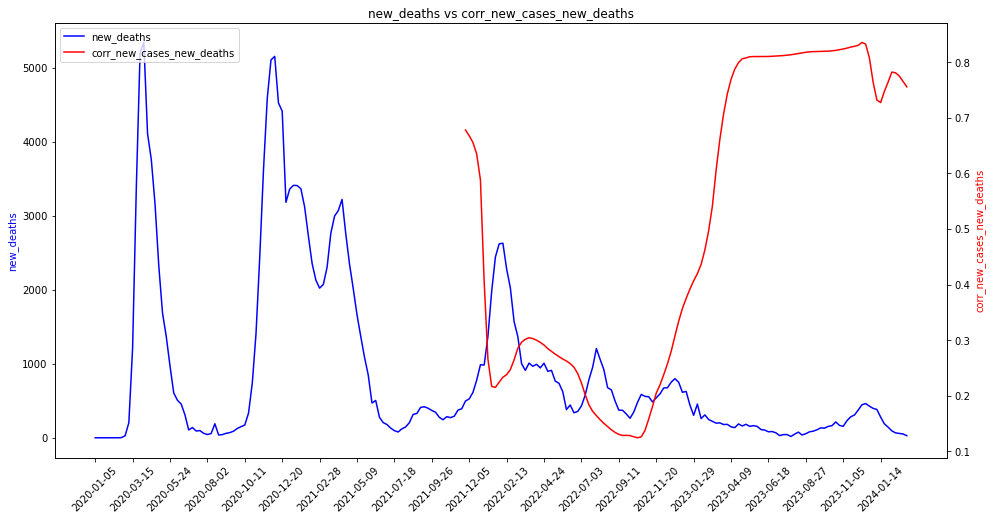

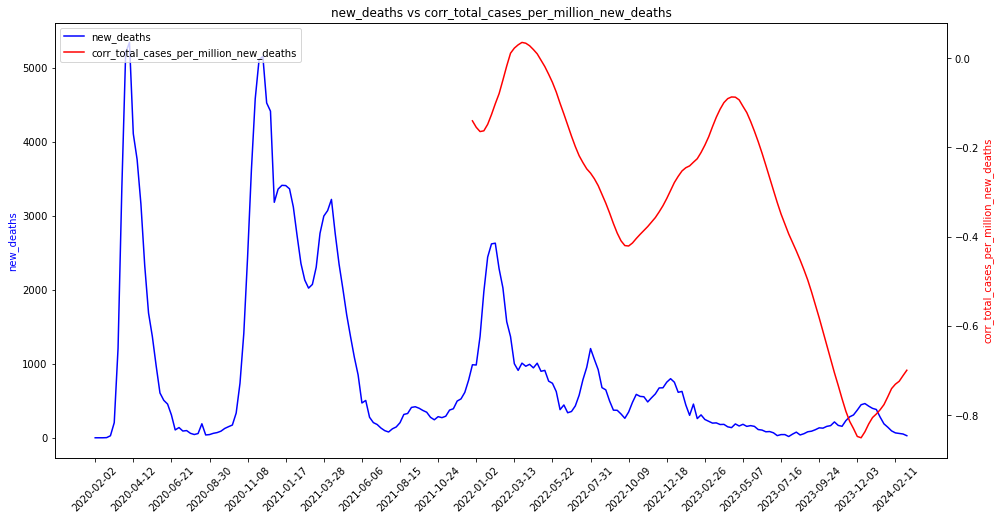

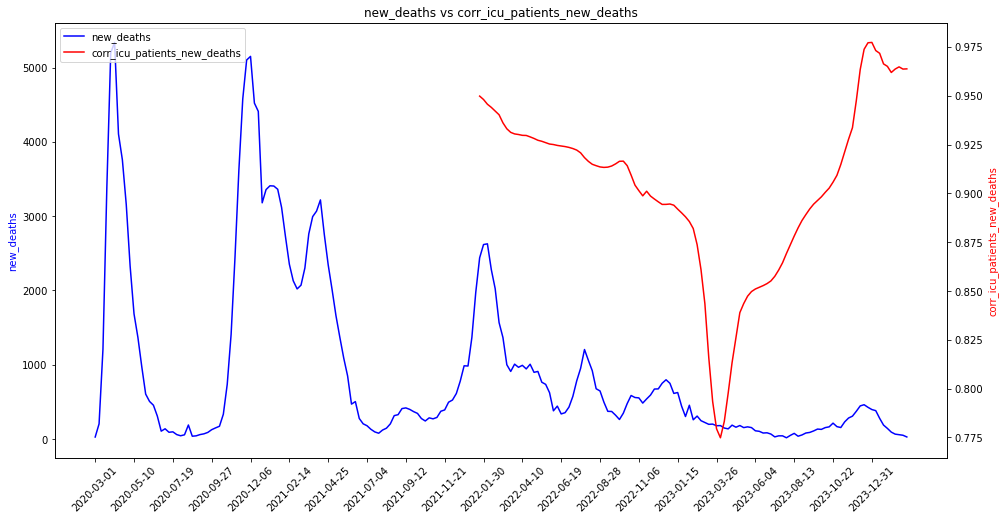

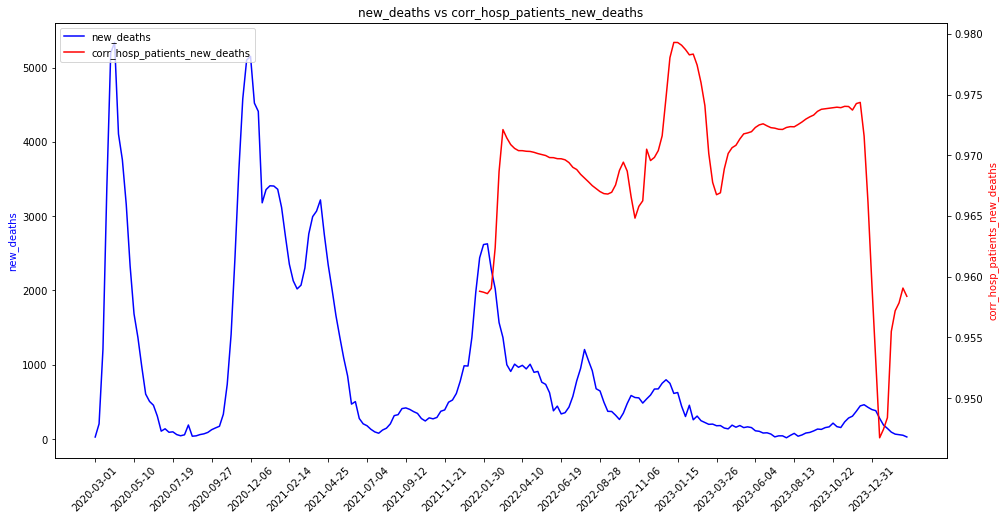

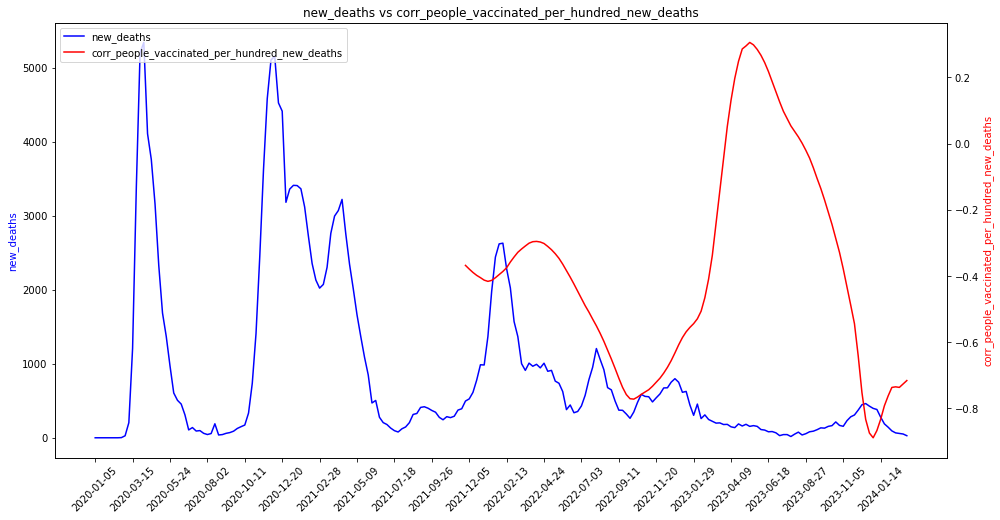

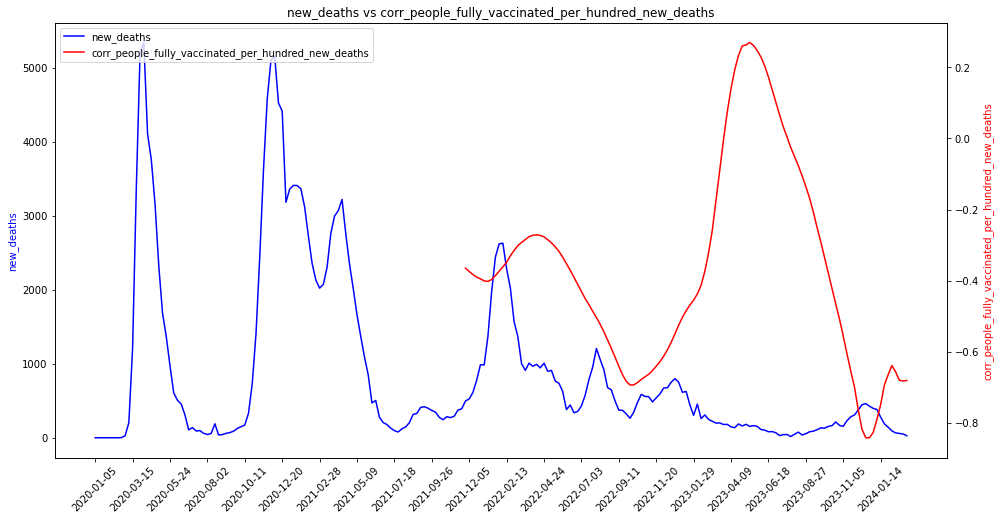

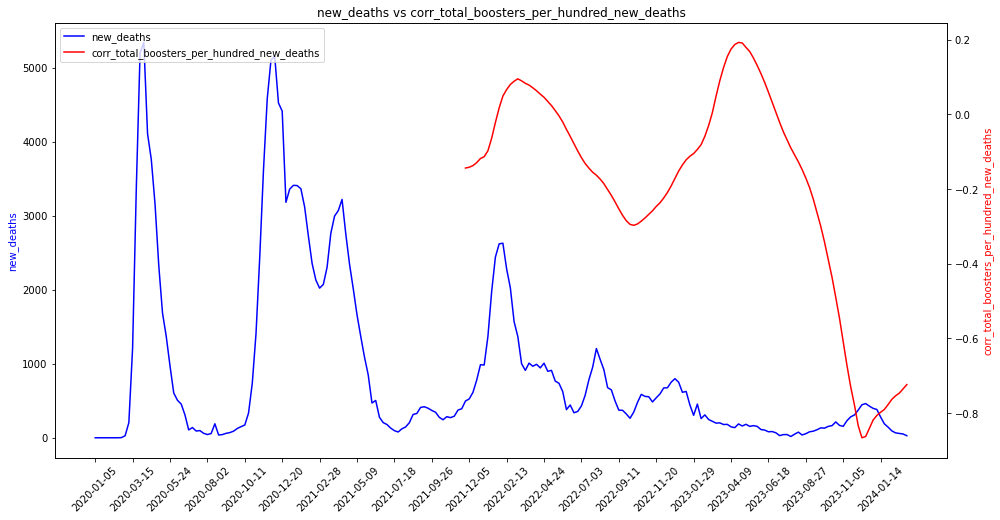

In [262]:
target_var = 'new_deaths'
for col in weekly_df.columns:
    if col != target_var:
        print_correlation_over_time(weekly_df,  col,target_var)

We can see that most of the variables correlation changes significantly over time.
In case we would perform a rolling correlation we will have to chose a very small window that wouldn' allow the robustness necessary to estimate 100 weeks.
<br>
We can eliminate the new case variable and proceed with the encoding of the other vax variables.

In [263]:
col_to_fill = ['people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred','total_boosters_per_hundred' ]


In [264]:
weekly_df_encod = weekly_df.copy()

In [265]:
# transforming the variables into categorical ones
for col in col_to_fill: 
    max_val = weekly_df_encod[col].max()
    first_treshold = max_val/2
    bin_edges = [-1, first_treshold, max_val]
    weekly_df_encod['bin'] = weekly_df_encod['bin'] = pd.cut(weekly_df_encod['total_boosters_per_hundred'], bins=bin_edges, 
                                                           labels=['low','high']) 
    one_hot_encoded = pd.get_dummies(weekly_df_encod['bin'], prefix=col)
    one_hot_encoded.columns = [col + '_{}'.format(col_bin) for col_bin in one_hot_encoded.columns]

    # Drop the original variable
    weekly_df_encod.drop(columns=[col], inplace=True)
    weekly_df_encod.drop(columns=['bin'], inplace=True)



    # Concatenate the one-hot encoded variables with the original DataFrame
    weekly_df_encod = pd.concat([weekly_df_encod, one_hot_encoded], axis=1)

In [266]:
weekly_df_encod.columns

Index(['new_deaths', 'new_cases', 'total_cases_per_million', 'icu_patients',
       'hosp_patients',
       'people_vaccinated_per_hundred_people_vaccinated_per_hundred_low',
       'people_vaccinated_per_hundred_people_vaccinated_per_hundred_high',
       'people_fully_vaccinated_per_hundred_people_fully_vaccinated_per_hundred_low',
       'people_fully_vaccinated_per_hundred_people_fully_vaccinated_per_hundred_high',
       'total_boosters_per_hundred_total_boosters_per_hundred_low',
       'total_boosters_per_hundred_total_boosters_per_hundred_high'],
      dtype='object')

### Target Variable Analisis

In [298]:
import pmdarima
from pmdarima.arima import ndiffs, nsdiffs
import plotly.express as px
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### Stationarity test : Augmented Dickey-Fuller test

In [268]:
# Ho: the process is not stationary. We need, at least, a unit root
# H1: the process is stationary. We have to check different models (lags)

original_series = weekly_df_encod[target_var]
#s = 52
adf_test = sm.tsa.stattools.adfuller(original_series,maxlag=50)
# print("adf_test", adf_test) # first output "The test statistic", second output "p-value"
print("ADF test for the original series")
print("Statistic Value:" , adf_test[0])
print("p-value:" , adf_test[1])


ADF test for the original series
Statistic Value: -1.2134172487918038
p-value: 0.6677974831518549


We dont' have enough evidence to reject the null hypothesis therefore the series is not stationary.

In [269]:
s = 60
d = ndiffs(original_series, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(original_series, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)


Regular differences:  0
Seasonal differences: 0


The Adf statistics cannot suggest any number of difference either seasonal or regular one to make the series stationary. <br>Possibly it' s because there are cycle and trends inside of those data.

#### Ljung-Box test for autocorrelation in a time series

In [270]:
# H0 no autocorrelation
# H1 there is autocorrelation

box_test = sm.stats.acorr_ljungbox(original_series, lags=[50])

print("Box test for the original series\n",box_test)

Box test for the original series
       lb_stat      lb_pvalue
50  870.02658  4.286165e-150


The small p- value makes us reject the null hypothesis, therefore is it likley that this time series has autocorrelation and we can find a time series model

## Sarimax Auto correlation and partial auto correlation graphs

We are running the regression model with a dummy ARIMA model to analyze the residuals and check what kind time series model can fit them.

In [271]:
weekly_df_encod

,new_deaths,new_cases,total_cases_per_million,icu_patients,hosp_patients,people_vaccinated_per_hundred_people_vaccinated_per_hundred_low,people_vaccinated_per_hundred_people_vaccinated_per_hundred_high,people_fully_vaccinated_per_hundred_people_fully_vaccinated_per_hundred_low,people_fully_vaccinated_per_hundred_people_fully_vaccinated_per_hundred_high,total_boosters_per_hundred_total_boosters_per_hundred_low,total_boosters_per_hundred_total_boosters_per_hundred_high
2020-01-05,0.0,0.0,NaN,NaN,NaN,1,0,1,0,1,0
2020-01-12,0.0,0.0,NaN,NaN,NaN,1,0,1,0,1,0
2020-01-19,0.0,0.0,NaN,NaN,NaN,1,0,1,0,1,0
2020-01-26,0.0,0.0,NaN,NaN,NaN,1,0,1,0,1,0
2020-02-02,0.0,3.0,0.051000,NaN,NaN,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-02-04,93.0,3171.0,452379.736143,97.285714,2189.428571,0,1,0,1,0,1
2024-02-11,66.0,2450.0,452431.703429,82.142857,1810.571429,0,1,0,1,0,1
2024-02-18,59.0,1727.0,452471.452857,64.571429,1510.000000,0,1,0,1,0,1
2024-02-25,51.0,1244.0,452499.536286,48.571429,1335.571429,0,1,0,1,0,1


In [278]:
model_df = weekly_df_encod.fillna(0)

In [284]:
lines_with_null = model_df[model_df.isnull().any(axis=1)]
lines_with_null


In [296]:
original_series= model_df[target_var]

In [290]:
X = model_df.drop(columns=target_var)


In [291]:
model = SARIMAX(original_series, exog=X, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0))

# Fit the SARIMAX model
model_fit = model.fit(disp=0)

# Get residuals
residuals = model_fit.resid
coefficients = model_fit.params
print("coefficients:" ,coefficients)

coefficients: new_cases                                                                      -6.148745e-04
total_cases_per_million                                                        -2.292512e-03
icu_patients                                                                    3.965426e-01
hosp_patients                                                                   8.521915e-02
people_vaccinated_per_hundred_people_vaccinated_per_hundred_low                -1.515566e+01
people_vaccinated_per_hundred_people_vaccinated_per_hundred_high                2.960751e+02
people_fully_vaccinated_per_hundred_people_fully_vaccinated_per_hundred_low    -1.515566e+01
people_fully_vaccinated_per_hundred_people_fully_vaccinated_per_hundred_high    2.960751e+02
total_boosters_per_hundred_total_boosters_per_hundred_low                      -1.515566e+01
total_boosters_per_hundred_total_boosters_per_hundred_high                      2.960751e+02
sigma2                                                  

In [293]:
# Create a Pandas Series to store the residuals
residuals_series = pd.Series(residuals, name='Residuals')

fig = px.line(x=range(len(residuals_series)), y=residuals_series,
    title="Residuals Line Chart",
    labels={'x': 'Observation', 'y': 'Residual'},
    line_shape="linear")
fig.show()

The residuals are not distributed as white noise.

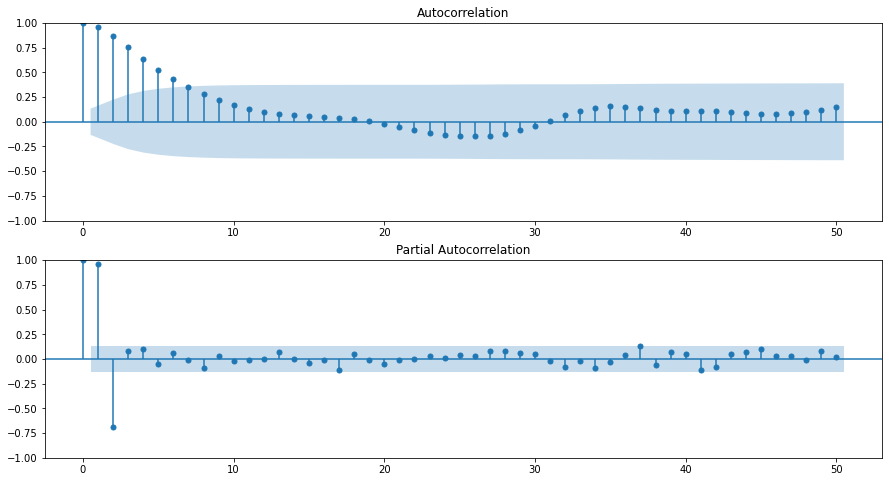

In [299]:

fig, ax = plt.subplots(2,1, figsize = (15,8))
# given the maximimun lag possible lags


plot_acf(original_series, lags = 50, ax=ax[0])
plot_pacf(original_series, lags = 50, method="ols", ax=ax[1])
plt.show()

From the previous partial autocorrelation graph it looks like there is a big autocorrelation with the 1st moment, so a regular difference is needed.

In [401]:
model = SARIMAX(original_series, exog=X, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))

# Fit the SARIMAX model
sarimax_fit = model.fit(disp=0)

# Get residuals
residuals = model_fit.resid
coefficients = model_fit.params
print("coefficients:" ,coefficients)

coefficients: new_cases                                                                      -4.417912e-04
total_cases_per_million                                                         3.749332e-03
icu_patients                                                                    9.840890e-01
hosp_patients                                                                   4.049151e-02
people_vaccinated_per_hundred_people_vaccinated_per_hundred_low                -5.018393e+01
people_vaccinated_per_hundred_people_vaccinated_per_hundred_high                5.018393e+01
people_fully_vaccinated_per_hundred_people_fully_vaccinated_per_hundred_low    -5.018393e+01
people_fully_vaccinated_per_hundred_people_fully_vaccinated_per_hundred_high    5.018393e+01
total_boosters_per_hundred_total_boosters_per_hundred_low                      -5.018393e+01
total_boosters_per_hundred_total_boosters_per_hundred_high                      5.018393e+01
sigma2                                                  

In [323]:
# Create a Pandas Series to store the residuals
residuals_series = pd.Series(residuals, name='Residuals')

fig = px.line(x=range(len(residuals_series)), y=residuals_series,
    title="Residuals Line Chart",
    labels={'x': 'Observation', 'y': 'Residual'},
    line_shape="linear")
fig.show()

The Variance of the residuals remains heteroskedastic

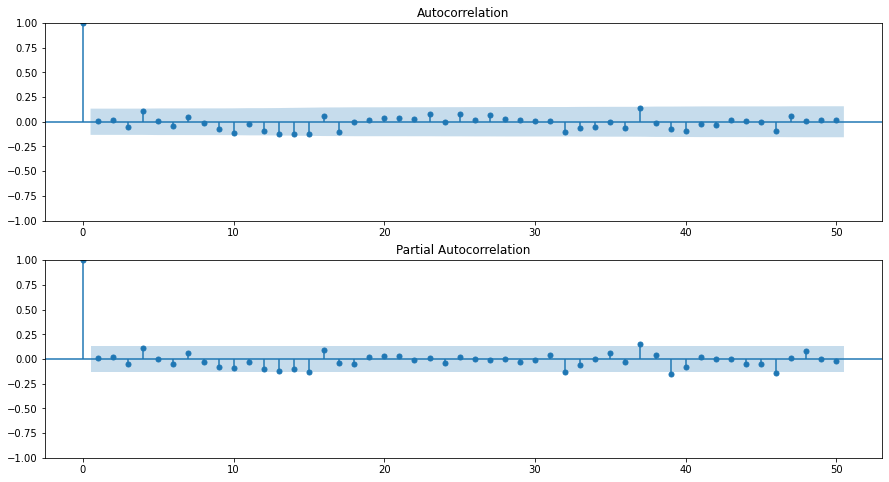

In [324]:

fig, ax = plt.subplots(2,1, figsize = (15,8))
# given the maximimun lag possible lags


plot_acf(residuals_series, lags = 50, ax=ax[0])
plot_pacf(residuals_series, lags = 50, method="ols", ax=ax[1])
plt.show()

all the lags are now in the confidence interval range 

In [328]:
# Ho: the process is not stationary. We need, at least, a unit root
# H1: the process is stationary. We have to check different models (lags)

original_series = model_df[target_var]
#s = 52
adf_test = sm.tsa.stattools.adfuller(residuals_series,maxlag=60)
# print("adf_test", adf_test) # first output "The test statistic", second output "p-value"
print("ADF test for the original series")
print("Statistic Value:" , adf_test[0])
print("p-value:" , adf_test[1])


ADF test for the original series
Statistic Value: -6.425399466006441
p-value: 1.7496499597938905e-08


The residuals are now stationary we found the model

## Predicting the Regressors

#### For all the vax dummy we can assume that we have the highest value for all cause the vaccinacion campaing is over 


In [388]:
max_index_model = model_df.index.max()

In [ ]:
#### the rest of variables will be prediced with the best arima model that the autoarima funcion can provide

In [335]:
start_timestamp = pd.Timestamp('2024-03-10 00:00:00', freq='W-SUN')

# Generate the DatetimeIndex for 100 more weeks
end_timestamp = start_timestamp + pd.Timedelta(weeks=100)
index = pd.date_range(start=start_timestamp, end=end_timestamp, freq='W-SUN')


prediction_df = pd.DataFrame( index=index, columns= list(model_df.columns))



In [343]:
models_diz =  {}
for col in prediction_df:
    if 'high' in col: 
        prediction_df[col] = 1
    elif 'low' in col:
        prediction_df[col] = 0
    else:
        key = col
        value = auto_arima(residuals_series, seasonal=False)
        models_diz[key] = value

In [344]:
models_diz

{'new_deaths': ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 'new_cases': ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 'total_cases_per_million': ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 'icu_patients': ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 'hosp_patients': ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
       with_intercept=False)}

Since there are no possible time series model to be applyed without a more accurate analysis over each variable we are gonna use a moving averege model for each one of those.

In [422]:
list_others = ['new_deaths', 'new_cases', 'total_cases_per_million', 'icu_patients',
       'hosp_patients']
combined_df = pd.concat([model_df, prediction_df])
combined_df = combined_df.fillna(combined_df.rolling(102,min_periods=1).mean())
pred_x = combined_df[combined_df.index > max_index_model].copy()
pred_x.drop(columns = [target_var] ,inplace = True)

Let us use the previously fitted Sarimax model to predict the number of new deaths.

In [455]:

exog_forecast = pred_x 

# Make predictions using the SARIMA model with exogenous variables
forecast_values= sarimax_fit.forecast(steps=len(exog_forecast), exog=exog_forecast)

# Display the forecast DataFrame
print(forecast_values)

2024-03-10    82.473944
2024-03-17    84.942895
2024-03-24    87.013390
2024-03-31    89.128814
2024-04-07    91.194186
                ...    
2026-01-11    70.184562
2026-01-18    56.943981
2026-01-25    44.786028
2026-02-01    34.967116
2026-02-08    28.000000
Freq: W-SUN, Name: predicted_mean, Length: 101, dtype: float64


### The Results

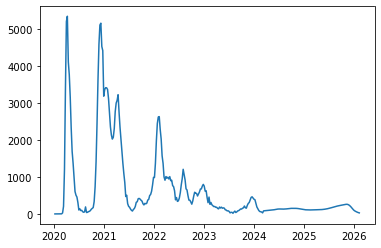

In [461]:
concatenated_series = pd.concat([model_df['new_deaths'], prediction_df['new_deaths']])
plt.plot(concatenated_series)
plt.show()

### Backtesting out of sample 

In [467]:
last_valid_index = model_df.index [-100]

In [486]:
exogenous = model_df.loc[last_valid_index :]

In [487]:
real_values = exogenous[ target_var].copy()
real_values

2022-04-10     992.0
2022-04-17     944.0
2022-04-24    1007.0
2022-05-01     898.0
2022-05-08     910.0
               ...  
2024-02-04      93.0
2024-02-11      66.0
2024-02-18      59.0
2024-02-25      51.0
2024-03-03      28.0
Freq: W-SUN, Name: new_deaths, Length: 100, dtype: float64

In [488]:
exogenous.drop(columns= target_var,inplace = True)

In [489]:
train = model_df.loc[: last_valid_index ]
original_series = train[target_var]
train.drop(columns = [target_var], inplace = True)

In [490]:
model = SARIMAX(original_series, exog=train, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))

# Fit the SARIMAX model
sarimax_fit_ = model.fit(disp=0)

# Get residuals
residuals = model_fit.resid
coefficients = model_fit.params
print("coefficients:" ,coefficients)

coefficients: new_cases                                                                      -4.417912e-04
total_cases_per_million                                                         3.749332e-03
icu_patients                                                                    9.840890e-01
hosp_patients                                                                   4.049151e-02
people_vaccinated_per_hundred_people_vaccinated_per_hundred_low                -5.018393e+01
people_vaccinated_per_hundred_people_vaccinated_per_hundred_high                5.018393e+01
people_fully_vaccinated_per_hundred_people_fully_vaccinated_per_hundred_low    -5.018393e+01
people_fully_vaccinated_per_hundred_people_fully_vaccinated_per_hundred_high    5.018393e+01
total_boosters_per_hundred_total_boosters_per_hundred_low                      -5.018393e+01
total_boosters_per_hundred_total_boosters_per_hundred_high                      5.018393e+01
sigma2                                                  

In [491]:

exog_forecast = pred_x 

# Make predictions using the SARIMA model with exogenous variables
forecast_values= sarimax_fit_.forecast(steps=len(exogenous), exog=exogenous)


In [493]:
forecast_values

2022-04-17     992.000000
2022-04-24    1002.567041
2022-05-01    1021.612234
2022-05-08    1043.880990
2022-05-15    1074.125002
                 ...     
2024-02-11    1705.404769
2024-02-18    1680.427565
2024-02-25    1654.349818
2024-03-03    1632.671069
2024-03-10    1620.056660
Freq: W-SUN, Name: predicted_mean, Length: 100, dtype: float64

In [494]:
real_values = real_values[1:]

In [496]:
eval_df = pd.DataFrame({'real_values': real_values, 'predicted': forecast_values})

In [497]:
eval_df['res_abs'] = abs(eval_df['real_values'] - eval_df['predicted'])
eval_df['mape'] = eval_df['res_abs'] / eval_df['real_values']
eval_df['mape'].mean()

In [498]:
the Mean of the Mape's is very high, so this model has a poor performance.
Some other analysis would be required to improve the model performance.

9.48415801867177

 ### Improvments points

Analyze and predict the regressors with another methodology that suits better
<br>
Include some lags of the regressor, we can evaluate the correlation between the target variable and the regressor's lags through the cross correlation function.

<br>
Implement a backtesting code that take into account more moment of the prediction and don't evaluate just the last prevision.
